In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
%matplotlib inline

# Chapter 4: Traning Models

- *Why understand the math behind machine learnings models?* (Q)
    - Quickly hone in on appropriate algorithms, or discard inappropriate ones
    - Easily narrow down the search space of hyperparameters
    - UNderstand debugging and model analysis

# Linear Regression

- Linear Regression is a conceptually simple model that predicts by computing a weighted sum of the input features, plus offset
    - $\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n $
    - Or, more compactly, $\hat{y} = h_\theta(\mathbf{x}) = \pmb{\theta} \cdot \pmb{x} = \pmb{\theta}^\intercal \pmb{x} $
        - 1st feature in the $\pmb{x}$ vector is always 1, to create the offset
        - $h_\theta(\pmb{x})$ is the hypothesis function, which describes the target as a function of the features
        - The value of $ \pmb{\theta} $ that minimizes the RMSE gives the model with best fit
        - In practice, it is easier to minimize the MSE instead of the RMSE.  This gives the same reuslt

- Mean Squared Error (MSE) is a measure of the average "miss" of the predictions from the ground truth:
$$ MSE(\pmb{X}, h_\theta) = \frac{1}{m} \sum_{i=1}^{m} (\pmb{\theta}^\intercal \pmb{x}_i - y_i )^{2} $$

- Root Mean Squared Error (RMSE) is simply the square root of the MSE:
$$ RMSE(\pmb{X}, h_\theta) = \sqrt{MSE(\pmb{X}, h_\theta)} $$

- *In what situation would you train a machine learning model with a different loss function than the function used to evaluate model performance?* (Q)
    - A different function might be easier/quicker to compute, such as using MSE instead of RMSE to fit a Linear Regression model
    - A different function might be easier to differentiate
    - In order to contrain the model, such as in a regularization setting

- The *Normal Equation* gives the closed-form solution to the optimization problem:
$$ \hat{\pmb{\theta}} = (\pmb{X}^\intercal \pmb{X})^{-1} \pmb{X}^\intercal \pmb{y} $$

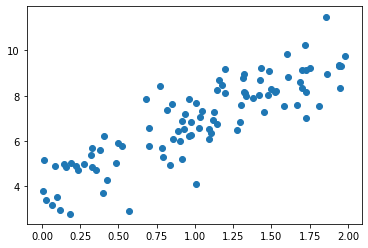

In [2]:
# An example
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)  # Normally distributed noise

plt.scatter(X, y);

In [3]:
# Compute the solution using the normal equation.
# This implementation calls out the fact that the solution
# is achieved with a chain of matrix multiplications

X_withbias = np.c_[np.ones(X.shape), X]
theta_hat = np.linalg.inv(X_withbias.T.dot(X_withbias)).dot(X_withbias.T).dot(y)  # Normal equation

In [4]:
# theta_hat is close to, but doens't precisely equal, the
# values hardcoded in the cell above.
theta_hat

array([[3.95520859],
       [2.87232069]])

In [5]:
X_new = np.array([[0], [2]])
X_new_withbias = np.c_[np.ones(X_new.shape), X_new]
y_pred = X_new_withbias.dot(theta_hat)

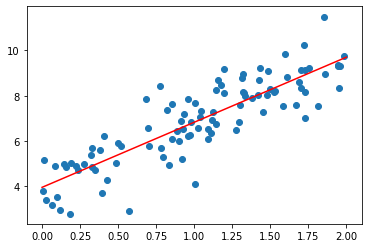

In [6]:
plt.scatter(X, y)
plt.plot(X_new, y_pred, color="red");

In [7]:
# Another example, this time using sklearn
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
# Again, the learned parameters approximate, but don't equal,
# the hardcoded values.
lin_reg.coef_, lin_reg.intercept_

(array([[2.87232069]]), array([3.95520859]))

In [9]:
# Finally, another example using numpy, which the sklearn
# implementation is based on.
theta_hat_svd, resid, rank, s = np.linalg.lstsq(X_withbias, y, rcond=1e-6)
theta_hat_svd

array([[3.95520859],
       [2.87232069]])

- The last example computes the Moore-Penrose (pseudo-)inverse of $\pmb{X}$:
    - $ \hat{\pmb{\theta}} = \pmb{X}^{+}\pmb{y} $
    - Can be computed directly with `np.linalg.pinv(X_withbias).dot(y)`
    - Moorse-Penrose inverse is calculated using SVD
        - $ \pmb{U} \pmb{\Sigma} \pmb{V}^\intercal $
        - `np.linalg.svd()`
        - Computed by taking SVD of $\pmb{X}$, set all small values in $\pmb{\Sigma}$ to zero, invert all its nonzero values, then transpose to get $ \pmb{U} \pmb{\Sigma}^{+} \pmb{V}^\intercal $
    - This is more efficient than copmuting the normal equation
    - More robust to cases where $ \pmb{X}^\intercal \pmb{X} $ cannot be inverted (i.e. it's singular)
        - Such as $n_{cols} > n_{rows}$ or in multicollinearity setting

- Computational complexity of the Moore-Penrose approach is better than the Normal Equation approach
    - Moore-Penrose approach used by `sklearn` is about $O(n^2)$
    - Inversion of an $(n+1) \times (n+1)$ matrix as in the normal equation is about $O(n^{2.4})$ to $O(n^3)$
    - Efficiency of both approaches deteriorates in high dimensions
    - Linear in the number of rows, so both approaches work well with large datasets
    - Predictions are fast once model has been trained: linear w.r.t. both number of features and rows

## Gradient Descent

- In addition to the analytic method described above, a gradient descent-based method can be used
- Gradient descent is a generic algorithm that can be used to find an optimum solution to many problems
- The idea is to iteratively update model parameters in such a way that the loss is progressively minimized
- Step size, i.e. learning rate, is an important parameter in the algorithm
    - Too-large step size can cause the algorithm to diverge
    - Too-small step size lengthens the time needed to converge
    - In practice, learning rate is progressively decreased to better "hone in" on an optimum
- Number of iterations must also be set well
    - Too low and the algorithm won't yet have arrived at the optimum
    - Too high is inefficient once the parameters stop changing
- In practice, it is useful to "early stop" the algorithm once the gradient gets very small, i.e. has a norm below $ \epsilon $, the tolerance
    - When the loss is convex, the alrogithm takes $ O(\frac{1}{\epsilon}) $ time to reach the optimum.  Dividing $\epsilon$ by 10 increases can increase the time by a factor of 10.

- Gradient descent can't be guaranteed to find the global minimum in a complex loss landscape
- However, if the loss function is convex, Gradient Descent will converge (given a not-too-large learning rate)

- Gradient descent benefits from features being scaled, otherwise it can take longer to converge

- To implement the Gradient Descent algorithmL
    - Compute the gradient of the cost function w.r.t. each parameter $\theta_j$
        - In the linear regrerssion example, this is $$ \frac{\partial}{\partial \theta_j}MSE(\pmb{\theta}) = \frac{2}{m}\sum_{i=1}^{m} (\pmb{\theta}^\intercal \pmb{x}_i - y_i)x_{ij} $$
        - This can be computed in one go: $$ \nabla_{\theta}MSE(\pmb{\theta}) = \frac{2}{m}\pmb{X}^\intercal(\pmb{X}\pmb{\theta} - \pmb{y}) $$
    - The gradient is a vector of partial derivatives, with length equal to the number of model parameters
    - Note that this requires computing the gradient over the _entire_ training set at each step in the descent.  This is not very efficient, so there are modifications to the algorithm that give a speedup
    - Finally, compute the next step in terms of the previous step: $$ \pmb{\theta}_{next} = \pmb{\theta} = \eta\nabla_{\theta}MSE(\pmb{\theta}) $$

In [10]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_withbias.T.dot(X_withbias.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[3.95520859],
       [2.87232069]])

- Stochastic Gradient Descent balances the advantages and disadvantages of calculating the gradient on the entire training data set
    - Computationally expensive to use entire training set, but contains the most information possible
    - SGD performs the process on a single training instance per iteration, instead of the entire training set
    - Result is a faster algorithm, the speed of which comes at the cost of less reliable gradient information
    - As a result, model loss is more likely to "bounce around" before settling at the optimum
    - Also, the alrgorithm will stop close to, but not on the optimum point
    - In practice, slowly decreasing the learning rate helps prevent the algorithm from jumping off the optimum by too much
    - Too-fast reduction may result in the algorithm being stuck in a local minimum
    - Too-slow reduction may reuslt in ending up fairly far from the actual optimum point

In [11]:
# numpy implementation

n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_withbias[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m * i)
        theta = theta - eta * gradients

In [12]:
theta

array([[3.74427192],
       [2.47650661]])

In [13]:
# sklearn's SGDRegression defaults to using MSE cost function

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [14]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.92360611]), array([2.85599294]))

- Minibatch Gradient Descent is a compromise between the efficieny of SGD and the quality of computing the gradient on the entire training set
- Minibatch Gradient Descent selects a random "mini-batch" of training data at each iteration to compute the gradient

## Polynomial Regression

- Polynomial regression models the data as a curve, rather than a stright line
- Adds higher-order features
    - Enables the response to vary with a feature $x$, based on the current level of $x$

In [15]:
# Some simulated data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

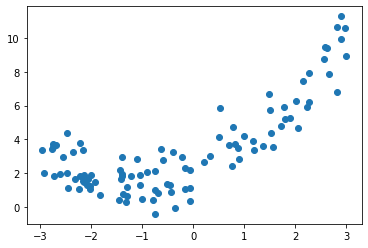

In [16]:
plt.scatter(X, y);

In [17]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [18]:
lin_reg  = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.05620339]), array([[1.12364823, 0.50838574]]))

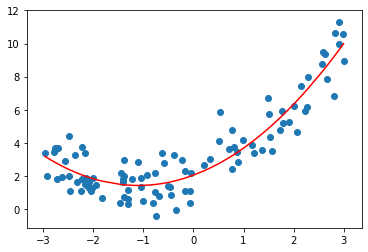

In [19]:
y_hat = lin_reg.predict(X_poly)
ixs = X.T.argsort()[0]
plt.plot(X[ixs], y_hat[ixs], color='red')
plt.scatter(X, y);

- Polynomial Regression can also be used to create interaction terms between the features
- This is powerful but can result in combinatorial explosion
    - A degree of `d` used on a dataset with `n` features will results in $\frac{(n+d)!}{d!n!}$ features!

- Learning Curves are another way to asses under/overfit of a model
    - Plots the model's performance on the training set, as a function of $n$

In [20]:
def plot_learning_curves(model, X, y, ymax=None):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    if ymax is not None:
        plt.ylim(0, ymax)
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()

Learning curve of a degree-1 Linear Regression

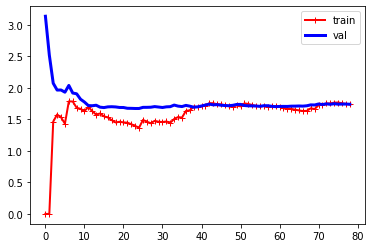

In [21]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

- Characteristic of underfitting: both curves plateau at a high level, and close to each other
- When model underfits, adding training data does not improve validation loss at all
- Training loss curve grows from zero because it can fit very well when there are only a few data points.
    - Stabilizes at the point at which adding data doesn't make th model any worse
- Validation loss curve initially starts high because the model trained on little data generalizes very poorly
    - Loss declines as generalization ability improves
    - Stabilizes at a point where the model is too inflexible to generalize any more

Learning Curve of a degree-10 Polynomial Regression

In [22]:
poly_reg = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

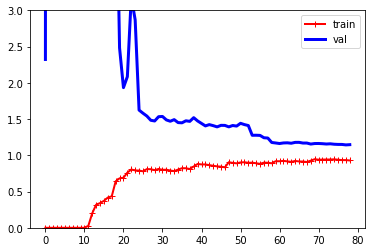

In [23]:
plot_learning_curves(poly_reg, X, y, ymax=3)

- There are some telltale signs that this model is more flexible than the linear regression:
    - The level of the training error is lower here than in the inflexible model
    - The gap between the curves shows that the model performs much better on the training data then the validation set (overfitting)
    - Using more data would tend to push the curves closer together

- The Bias-Variance tradeoff states that a model's feneralization error can be decomposed into three:
    - Bias: The inflexibility built into a model as the result of its assumptions about the data
    - Variance: The error that comes from sensitivity to changes in the data as the result of being "too" flexible
    - Irreducible error: Noise that can never be eliminated even with an oracle model
- The tradeoff captures the notion that increasing a model's flexibility redues its bias while increasing its variance
- Idea model minimizes the sum of (squared) bias and variance

## Regularized Linear Models

- Regularization is a general technique for contraining a model and thus reducing its susceptibility to overfitting
- Operates by penalizing a more flexible model; induces model to add flexibility only "where it really needs to"
- In linear models, a straightforward way to regularize is to penalize the magnitude of the weights
    - Induces model to "pick which weights matter the most"
    - Requires features to be scaled; differing scales of features will distort results
    - Strength of penalty depends on a hyperparameter

### Ridge Regression

- Ridge Regression adds a penalty of $\alpha\sum_{i=1}^{n}\theta_i^2$ to the cost function
    - Larger weights add more to the cost function, quardratically
    - $\alpha$ controls the tradeoff between fit and penalty ($\alpha=0$ reduces to unregularized model; high $\alpha$ reduces flexbility)
    - Induces the model to keep the weights as small as possible
    - Results in a more stable model than unregularized model when some features are very highly correlated
    - It only makes sense to use the penalty for training!  When evaluating the models performance, only makes sense to use the unregularized performance measure
    - Does not make sense to regularize the bias term (note that the index starts at 1, not 0, below)
    - Complete cost function: $$ J(\pmb{\theta}) = MSE(\pmb{\theta}) + \alpha\frac{1}{2}\sum_{i=1}^{n}\theta_i^2 $$
    - Can also be represented as $$ \frac{1}{2} \|{ \pmb{w} }\|_2^2 $$
    - Adds $\alpha\pmb{w}$ to the MSE gradient vector, if using gradient descent

- Closed-form solution to Ridge equation is $$ \hat{\pmb{\theta}} = (\pmb{X}^\intercal \pmb{X} + \alpha\pmb{A})^{-1}\pmb{X}^\intercal \pmb{y} $$
    - The $\alpha\pmb{A}$ term is added over the vanilla model
    - $\pmb{A}$ is the identity matrix of dimension $(n+1)\times(n+1)$, but with a zero in the top-left coner for the bias term

In [24]:
# Solves the Ridge problem via the closed form solutions
# Uses a matrix factorization technique from Cholesky
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.39495461]])

In [25]:
# Solves using Gradient Descent
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.38343427])

### LASSO Regression

- LASSO is a regularization technique that uses the $\ell_1$ norm of the weights vector as the penalty, instead of the $\ell_2$ norm
    - "Least Absolute Shrinkage and Selection Operator"
    - Complete cost function therefore is: $$ J(\pmb{\theta}) = MSE(\pmb{\theta}) + \alpha\sum_{i=1}^{n}|{\theta_i}| $$
    - A major difference compared to Ridge regression is what the weights are induced to do:
        - Ridge penalty tends to result in weight being close to, but not exaclty, zero
        - LASSO penalty pushes many weights to exactly zero
        - For this reason, LASSO can serve as a method of automatic feature selection
    - Less stable convergance than Ridge.  If using Gradient Descent, need to gradually reduce the learning rate

- Due to the $\ell_1$ norm term, the LASSO loss is not differentiable when a $\theta_i = 0$.  Thus a subgradient vector is needed instead: $$ g(J, \pmb{\theta}) = \nabla_{\theta}MSE(\pmb{\theta}) + \alpha
  \begin{align}
    \begin{bmatrix}
           sign(\theta_1) \\
           sign(\theta_2) \\
           \vdots \\
           sign(\theta_n)
         \end{bmatrix}
  \end{align} $$

- Graphical understanding of this difference:
    - Consider a 2-parameter model, and the values of the parameters are plotted on two axes
    - At a given value of $\alpha$, the LASSO penalty decreases linearly as you approach either axis
    - A fixed "budget" of parameter weight can be visualized as a circle with a given radius around the origin
    - The LASSO penalty is minimized at the points where that circle crosses an axis, which is where one of the parameters equls zero
    - By contrast, the Ridge penalty decreases with the distance to the origin, so the optimum is not "attracted to the gutter" i.e. one of the axes

In [31]:
# Sklearn example of LASSO
lasso_reg = Lasso(alpha=0.1)
lasso_reg .fit(X, y)
lasso_reg.predict([[1.5]])

array([5.34528696])

In [33]:
# Using SGDRegressor
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.40506333])

### Elastic Net

- Elastic Net occupies a "middle ground" between $\ell_1$ and $\ell_2$ regularization
- Elastic Net cost fuction: $$ J(\pmb{\theta}) = MSE(\pmb{\theta}) + r\alpha\sum_{i=1}^{n}|\theta_i| + \frac{1-r}{2}\alpha\sum_{i=1}^{n}\theta_i^2 $$
- Penalty is a mix of $\ell_1$ and $\ell_2$ pentalties:
    - Overall amount of penalty is controlled y $\alpha$ hyperparameter
    - Relative strength between the penalty terms is controlled by $r$ hyperparameter
- Elastic Net can be more stable than LASSO in situations where there are more features than samples, or if many features are very highly correlated

In [34]:
# sklearn example
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.34289799])

### Early Stopping

- Iterative learning algorithms may also be regularized differently: by stopping the learning process after validation error reaches a minimum
    - Intuition relates back to the learning rates graph: the point at which validation error stops decreasing and starts to increase is a sign the model has started to overfit, and is no longer generalizing as well as it can
    - In practice, due to non-smooth validation curves, the criterion is usually to stop after the validation curve has been above the minimum for some time, then roll back to the minimum

Stopped at the implementation of early stopping, page 204